# Week 2 — Data Handling & Cleaning
Goal: parse ClinVar VCF, clean ClinVar summary, map labels (0/1), save ML-ready CSV, and document decisions.


In [23]:
# Cell 2
import os, sys
import pandas as pd
import numpy as np
import vcfpy
import matplotlib.pyplot as plt

# paths
DATA_DIR = "data"
CLINVAR_SUMMARY = os.path.join(DATA_DIR, "variant_summary.txt.gz")
VCF_PLAIN = os.path.join(DATA_DIR, "clinvar.vcf")        # plain VCF
VCF_GZ = os.path.join(DATA_DIR, "clinvar.vcf.gz")       # gz VCF (if zipped)
OUT_LABELED = os.path.join(DATA_DIR, "clinvar_labeled.csv")
OUT_MLREADY = os.path.join(DATA_DIR, "clinvar_ml_ready.csv")

print("Files in data:", os.listdir(DATA_DIR))
print("ClinVar summary exists:", os.path.exists(CLINVAR_SUMMARY))
print("ClinVar VCF plain exists:", os.path.exists(VCF_PLAIN))
print("ClinVar VCF gz exists:", os.path.exists(VCF_GZ))


Files in data: ['.ipynb_checkpoints', 'clinvar.vcf', 'clinvar.vcf.gz', 'clinvar.vcf.gz.tbi', 'clinvar_labeled.csv', 'clinvar_ml_ready.csv', 'Unconfirmed 243949.crdownload', 'variant_summary.txt', 'variant_summary.txt.gz']
ClinVar summary exists: True
ClinVar VCF plain exists: True
ClinVar VCF gz exists: True


In [24]:
import os
vcf_path = VCF_GZ if os.path.exists(VCF_GZ) else VCF_PLAIN
if not os.path.exists(vcf_path):
    print("⚠️ VCF not found at expected paths; skipping VCF preview.")
else:
    print("✅ VCF found:", vcf_path)
    reader = vcfpy.Reader.from_path(vcf_path)

    # ✅ UNIVERSAL fallback: extract INFO keys safely
    info_keys = []
    for line in reader.header.lines:
        if line.key == "INFO":
            info_keys.append(line.id)

    print("\nINFO definitions keys (sample):")
    print(info_keys[:20])

    # ✅ Preview a few variant records
    rows = []
    for i, rec in enumerate(reader):
        for alt in rec.ALT:
            rows.append({
                "chrom": rec.CHROM,
                "pos": rec.POS,
                "id": rec.ID,
                "ref": rec.REF,
                "alt": alt.value,
                "INFO": rec.INFO  # print full INFO dict for first few
            })
        if i >= 4:
            break

    import pandas as pd
    df_vcf_preview = pd.DataFrame(rows)
    display(df_vcf_preview.head())

✅ VCF found: data\clinvar.vcf.gz

INFO definitions keys (sample):
['AF_ESP', 'AF_EXAC', 'AF_TGP', 'ALLELEID', 'CLNDN', 'CLNDNINCL', 'CLNDISDB', 'CLNDISDBINCL', 'CLNHGVS', 'CLNREVSTAT', 'CLNSIG', 'CLNSIGCONF', 'CLNSIGINCL', 'CLNSIGSCV', 'CLNVC', 'CLNVCSO', 'CLNVI', 'DBVARID', 'GENEINFO', 'MC']


,chrom,pos,id,ref,alt,INFO
0,1,66926,[3385321],AG,A,"{'ALLELEID': 3544463, 'CLNDISDB': ['Human_Phen..."
1,1,69134,[2205837],A,G,"{'ALLELEID': 2193183, 'CLNDISDB': ['MedGen:CN1..."
2,1,69308,[3925305],A,G,"{'ALLELEID': 4039319, 'CLNDISDB': ['MedGen:CN1..."
3,1,69314,[3205580],T,G,"{'ALLELEID': 3374047, 'CLNDISDB': ['MedGen:CN1..."
4,1,69404,[3925306],T,C,"{'ALLELEID': 4039320, 'CLNDISDB': ['MedGen:CN1..."


In [25]:
# Cell 4
def map_label(s):
    """Return 1 for pathogenic/likely pathogenic, 0 for benign/likely benign, None otherwise."""
    if pd.isna(s): return None
    text = str(s).lower()
    has_path = "pathogenic" in text
    has_ben  = "benign" in text
    if has_path and not has_ben:
        return 1
    if has_ben and not has_path:
        return 0
    return None

# quick assert tests
assert map_label("Pathogenic")==1
assert map_label("Likely benign")==0
assert map_label("Uncertain significance") is None
print("map_label function ready")


map_label function ready


In [26]:
# Cell 5
clinvar_fn = CLINVAR_SUMMARY
out_csv = OUT_LABELED
chunksize = 200_000

cols_wanted = ["GeneSymbol","ClinicalSignificance","ReviewStatus",
               "Chromosome","Start","ReferenceAllele","AlternateAllele",
               "FunctionalConsequence","RS#(dbSNP)","AlleleID"]

first = True
total_in = total_out = 0
print("Reading and cleaning ClinVar summary...")

for chunk in pd.read_csv(clinvar_fn, sep="\t", chunksize=chunksize, low_memory=False):
    total_in += len(chunk)
    for c in cols_wanted:
        if c not in chunk.columns: chunk[c] = np.nan
    small = chunk[cols_wanted].copy()
    small['label'] = small['ClinicalSignificance'].map(map_label)
    small = small.dropna(subset=['label','Chromosome','Start','ReferenceAllele','AlternateAllele'])
    small['variant_key'] = (small['Chromosome'].astype(str).str.replace('chr','',case=False)
                            + ":" + small['Start'].astype(int).astype(str)
                            + ":" + small['ReferenceAllele'].astype(str)
                            + ":" + small['AlternateAllele'].astype(str))
    small = small.drop_duplicates(subset=['variant_key'])
    total_out += len(small)
    mode = "w" if first else "a"
    small.to_csv(out_csv, index=False, mode=mode, header=first)
    first=False

print(f"Done. Rows read: {total_in:,} Rows kept (labeled): {total_out:,}")


Reading and cleaning ClinVar summary...
Done. Rows read: 7,856,076 Rows kept (labeled): 3,470,638


In [31]:
# Cell 6
df_lab = pd.read_csv(OUT_LABELED)
print("Label counts (0=Benign,1=Pathogenic):")
print(df_lab['label'].value_counts(dropna=False))
display(df_lab.head())

Label counts (0=Benign,1=Pathogenic):
label
0.0    2519887
1.0     950751
Name: count, dtype: int64


,GeneSymbol,ClinicalSignificance,ReviewStatus,Chromosome,Start,ReferenceAllele,AlternateAllele,FunctionalConsequence,RS#(dbSNP),AlleleID,label,variant_key
0,AP5Z1,Pathogenic/Likely pathogenic,"criteria provided, multiple submitters, no con...",7,4820844,na,na,NaN,NaN,NaN,1.0,7:4820844:na:na
1,AP5Z1,Pathogenic/Likely pathogenic,"criteria provided, multiple submitters, no con...",7,4781213,na,na,NaN,NaN,NaN,1.0,7:4781213:na:na
2,AP5Z1,Pathogenic,no assertion criteria provided,7,4827361,na,na,NaN,NaN,NaN,1.0,7:4827361:na:na
3,AP5Z1,Pathogenic,no assertion criteria provided,7,4787730,na,na,NaN,NaN,NaN,1.0,7:4787730:na:na
4,FOXRED1,Pathogenic,"criteria provided, multiple submitters, no con...",11,126145284,na,na,NaN,NaN,NaN,1.0,11:126145284:na:na


In [28]:
# Cell 7
if 'df_vcf_preview' in globals() and not df_vcf_preview.empty:
    df_vcf = df_vcf_preview.copy()
    df_vcf['variant_key'] = (df_vcf['chrom'].astype(str).str.replace('chr','',case=False)
                              + ":" + df_vcf['pos'].astype(int).astype(str)
                              + ":" + df_vcf['ref'] + ":" + df_vcf['alt'])
    merged = df_vcf.merge(df_lab, on='variant_key', how='right')
    display(merged.head())
    # Save merged subset if useful
    merged.to_csv(OUT_MLREADY, index=False)
    print("Saved merged ml-ready CSV:", OUT_MLREADY)
else:
    # fallback: save df_lab as ml-ready
    df_lab.to_csv(OUT_MLREADY, index=False)
    print("Saved ml-ready CSV:", OUT_MLREADY)


,chrom,pos,id,ref,alt,INFO,variant_key,GeneSymbol,ClinicalSignificance,ReviewStatus,Chromosome,Start,ReferenceAllele,AlternateAllele,FunctionalConsequence,RS#(dbSNP),AlleleID,label
0,NaN,NaN,NaN,NaN,NaN,NaN,7:4820844:na:na,AP5Z1,Pathogenic/Likely pathogenic,"criteria provided, multiple submitters, no con...",7,4820844,na,na,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,7:4781213:na:na,AP5Z1,Pathogenic/Likely pathogenic,"criteria provided, multiple submitters, no con...",7,4781213,na,na,NaN,NaN,NaN,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,7:4827361:na:na,AP5Z1,Pathogenic,no assertion criteria provided,7,4827361,na,na,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,7:4787730:na:na,AP5Z1,Pathogenic,no assertion criteria provided,7,4787730,na,na,NaN,NaN,NaN,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,11:126145284:na:na,FOXRED1,Pathogenic,"criteria provided, multiple submitters, no con...",11,126145284,na,na,NaN,NaN,NaN,1.0


Saved merged ml-ready CSV: data\clinvar_ml_ready.csv


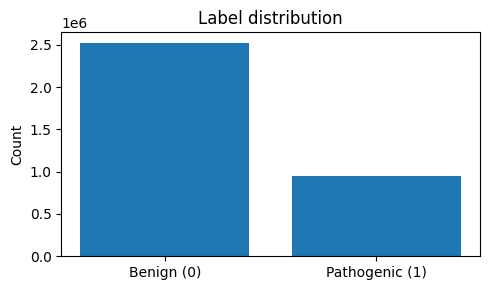

Label 0.0: 2,519,887 (72.61%)
Label 1.0: 950,751 (27.39%)


In [29]:
# Cell 8
import matplotlib.pyplot as plt
label_counts = df_lab['label'].value_counts().sort_index()
plt.figure(figsize=(5,3))
plt.bar(['Benign (0)','Pathogenic (1)'], label_counts.values)
plt.title("Label distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

total = label_counts.sum()
for lab,count in label_counts.items():
    print(f"Label {lab}: {count:,} ({count/total*100:.2f}%)")


In [30]:
# Cell 9
log_path = "docs/data_curation.md"
with open(log_path,"a", encoding="utf-8") as f:
    f.write("\n\n### Entry: ClinVar labeling\n")
    f.write("Date: \nAuthor: Aina Rif'ah\nFiles used: data/variant_summary.txt.gz\nActions: Mapped ClinicalSignificance -> binary label (Pathogenic/Likely pathogenic -> 1; Benign/Likely benign -> 0). Deduplicated, removed missing coordinates.\nOutput: data/clinvar_labeled.csv and data/clinvar_ml_ready.csv\nNotes: \n")
print("Created template entry in", log_path)


Created template entry in docs/data_curation.md


### Commit & push

Commands to run in project root (Anaconda Prompt):

git checkout -b feature/clinvar-clean
git add data/clinvar_labeled.csv data/clinvar_ml_ready.csv notebooks/02_data_cleaning.ipynb docs/data_curation.md docs/labeling_rules.md
git commit -m "Week2: ClinVar cleaning & labeling; added clinvar_ml_ready.csv and data curation log"
git push -u origin feature/clinvar-clean
